In [1]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import numpy as np
from pyuvdata import UVCal, UVData
import os
import sys
import glob
import uvtools as uvt
from astropy.time import Time
from astropy.coordinates import EarthLocation, AltAz, Angle
from astropy.coordinates import SkyCoord as sc
import pandas
import warnings 
import copy
from hera_notebook_templates import utils_h1c as utils
import hera_qm
from hera_mc import cm_hookup
import h5py
import importlib
from scipy import stats
import yaml
from IPython.display import display, HTML
#warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
display(HTML("<style>.container { width:100% !important; }</style>"))

/lustre/aoc/projects/hera/heramgr/anaconda3/envs/h1c_idr3_2_validation/lib/python3.9/site-packages/redis/connection.py:72: UserWarning: redis-py works best with hiredis. Please consider installing
  warnings.warn(msg)


In [2]:
# If you want to run this notebook locally, copy the output of the next cell into the first few lines of this cell.

# JD = 2458045
# data_path = "/lustre/aoc/projects/hera/H1C_IDR3/IDR3_2/2458045"
# flag_yaml_path = "/lustre/aoc/projects/hera/H1C_IDR3/IDR3_2/h1c_idr3_software/hera_pipelines/pipelines/h1c/idr3/v2/a_priori_flags"
# os.environ["JULIANDATE"] = str(JD)
# os.environ["DATA_PATH"] = data_path
# os.environ["PATH_TO_A_PRIORI_FLAGS"] = flag_yaml_path

In [3]:
#get data location
JD = os.environ['JULIANDATE']
data_path = os.environ['DATA_PATH']
flag_yaml_path = os.environ['PATH_TO_A_PRIORI_FLAGS']

print(f'JD = {JD}')
print(f'data_path = "{data_path}"')
print(f'flag_yaml_path = "{flag_yaml_path}"')

JD = 2458098
data_path = "/lustre/aoc/projects/hera/Validation/test-4.1.0/2458098"
flag_yaml_path = "/lustre/aoc/projects/hera/H1C_IDR3/IDR3_2/h1c_idr3_software/hera_pipelines/pipelines/h1c/idr3/v2/a_priori_flags"


In [4]:
utc = Time(JD, format='jd').datetime
print(f'Date: {utc.month}-{utc.day}-{utc.year}')

Date: 12-10-2017


In [5]:
# Load in data
HHfiles, uvdx, uvdy = utils.load_data(data_path,JD)
ex_ants = utils.read_a_priori_ant_flags(f'{flag_yaml_path}/{JD}.yaml')
    
uv = UVData()
unread = True
readInd=0
while unread and readInd<len(HHfiles):
    try:
        uv.read(HHfiles[readInd])
        unread = False
    except:
        readInd += 1
        continue
ants = uv.antenna_numbers
use_ants = [ant for ant in ants if ant not in ex_ants]
uvd = UVData()
uvd.read(HHfiles, ant_str='auto')
uvd.select(antenna_nums=use_ants)
lsts = uvd.lst_array
uvdx.select(antenna_nums=use_ants)
uvdy.select(antenna_nums=use_ants)

32 sum files found between JDs 2458098.26719 and 2458098.49835


## Sky Coverage Map 

Map of the sky (made using the Haslam 408MHz map). The RA/DEC range covered by this night of observation is shaded based on a 12 degree FWHM of the beam. Horizontal dashed lines represent the stripe that HERA can observe, while the shaded region is what was observed on this night. Vertical lines represent the beginning and ending LSTs of this observation. Selected sources are labelled, sources included are those in the GLEAM 4Jy catalog with a flux >10.9 Jy. Note that the map is clipped at the northern horizon.

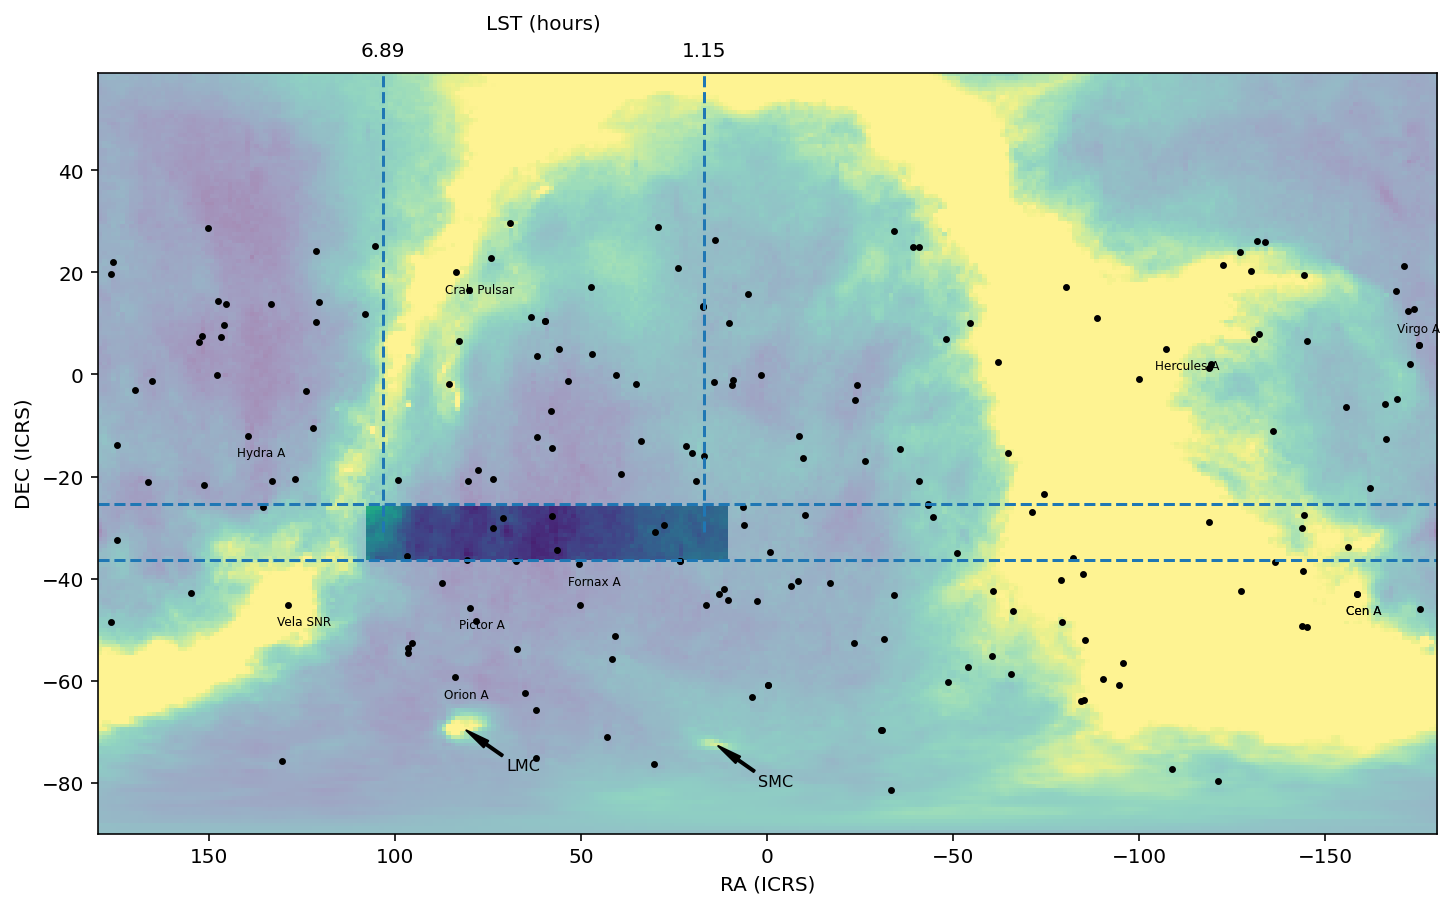

In [6]:
sources = utils.gather_source_list()
utils.plot_sky_map(uvd,dec_pad=55,ra_pad=55,clip=False,sources=sources)

## LST Coverage

Shows the LSTs (in hours) and JDs for which data is collected. Green represents data, red means no data.

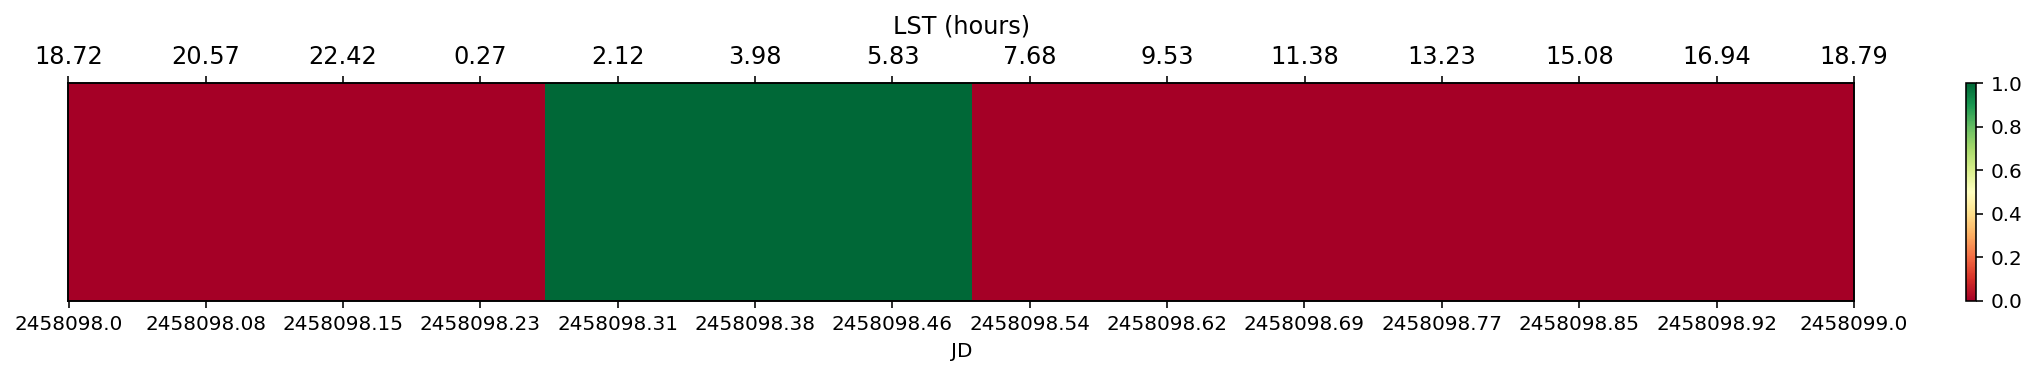

In [7]:
utils.plot_lst_coverage(uvd)

## Autocorrelations for a single file

This plot shows autocorrelations for one timestamp of each antenna that is active and each polarization. For each node, antennas are ordered by SNAP number, and within that by SNAP input number. The antenna number label color corresponds to the a priori status of that antenna.

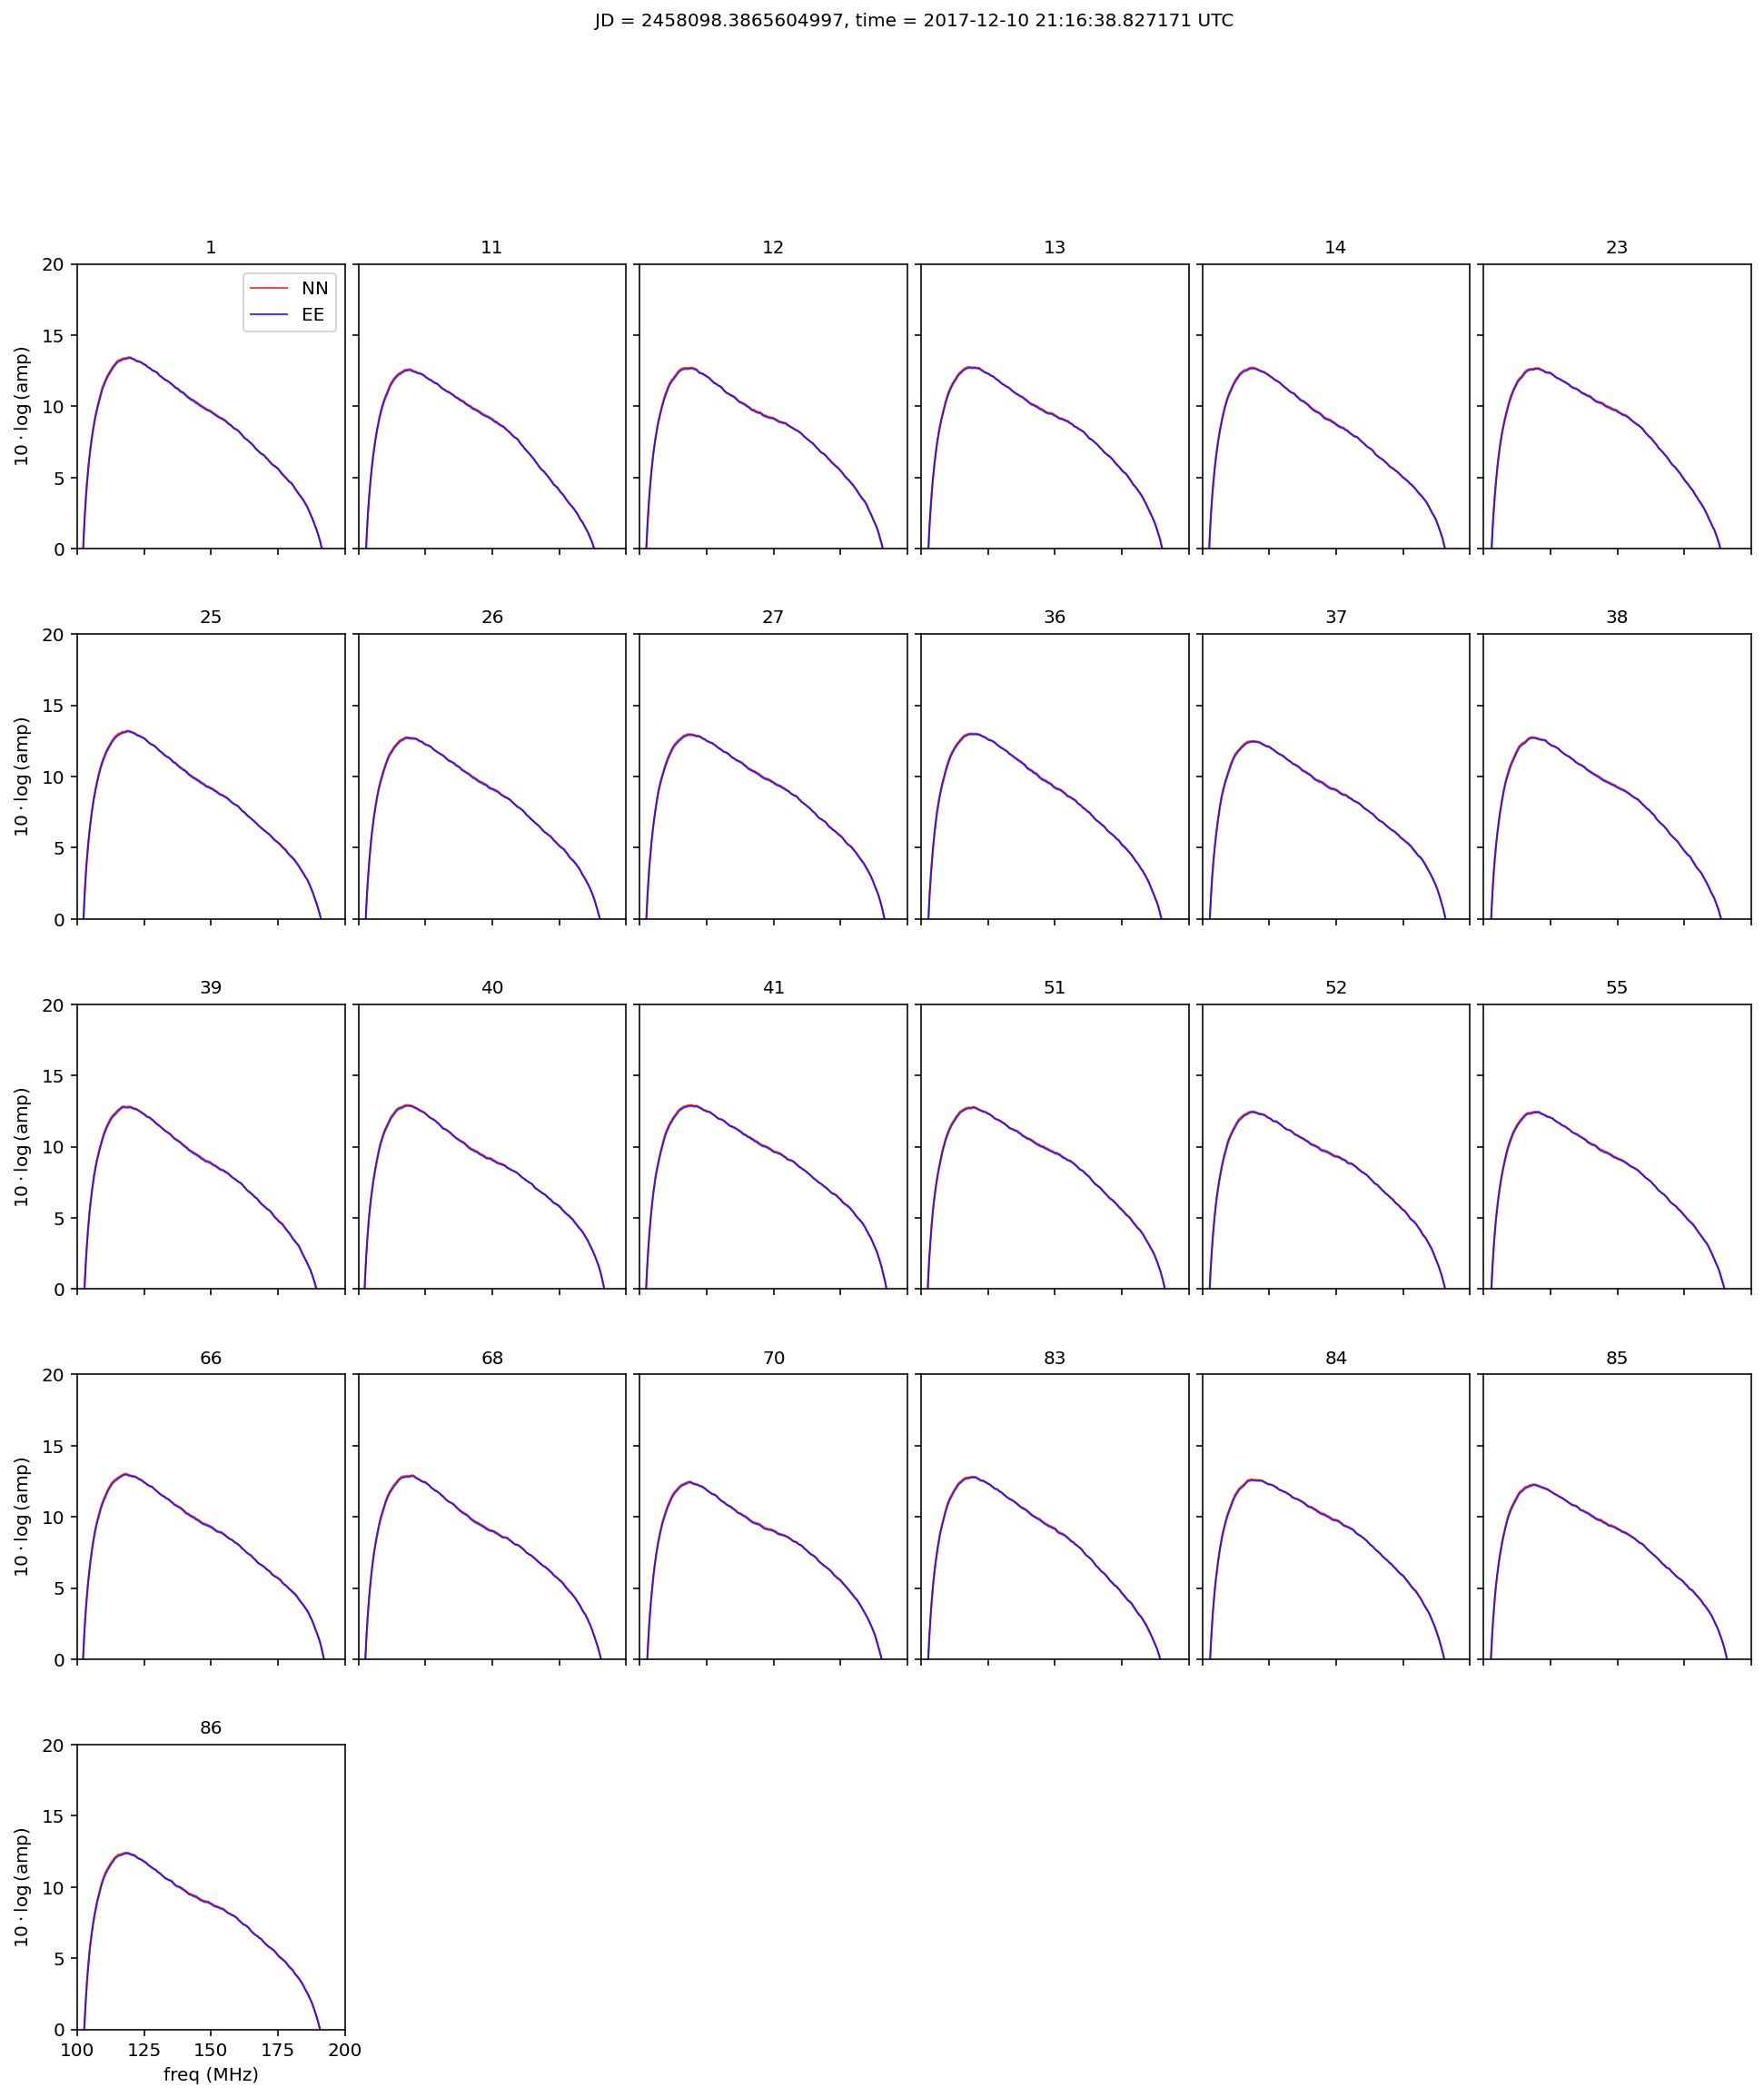

In [8]:
### plot autos
utils.plot_autos(uvdx, uvdy)

## Waterfalls of Autocorrelation Amplitudes for each Antenna and Each polarization

These plots show autocorrelation waterfalls of each antenna that is active and whose status qualifies for this notebook. For each node, antennas are ordered by SNAP number, and within that by SNAP input number. The antenna number label color corresponds to the a priori status of that antenna.

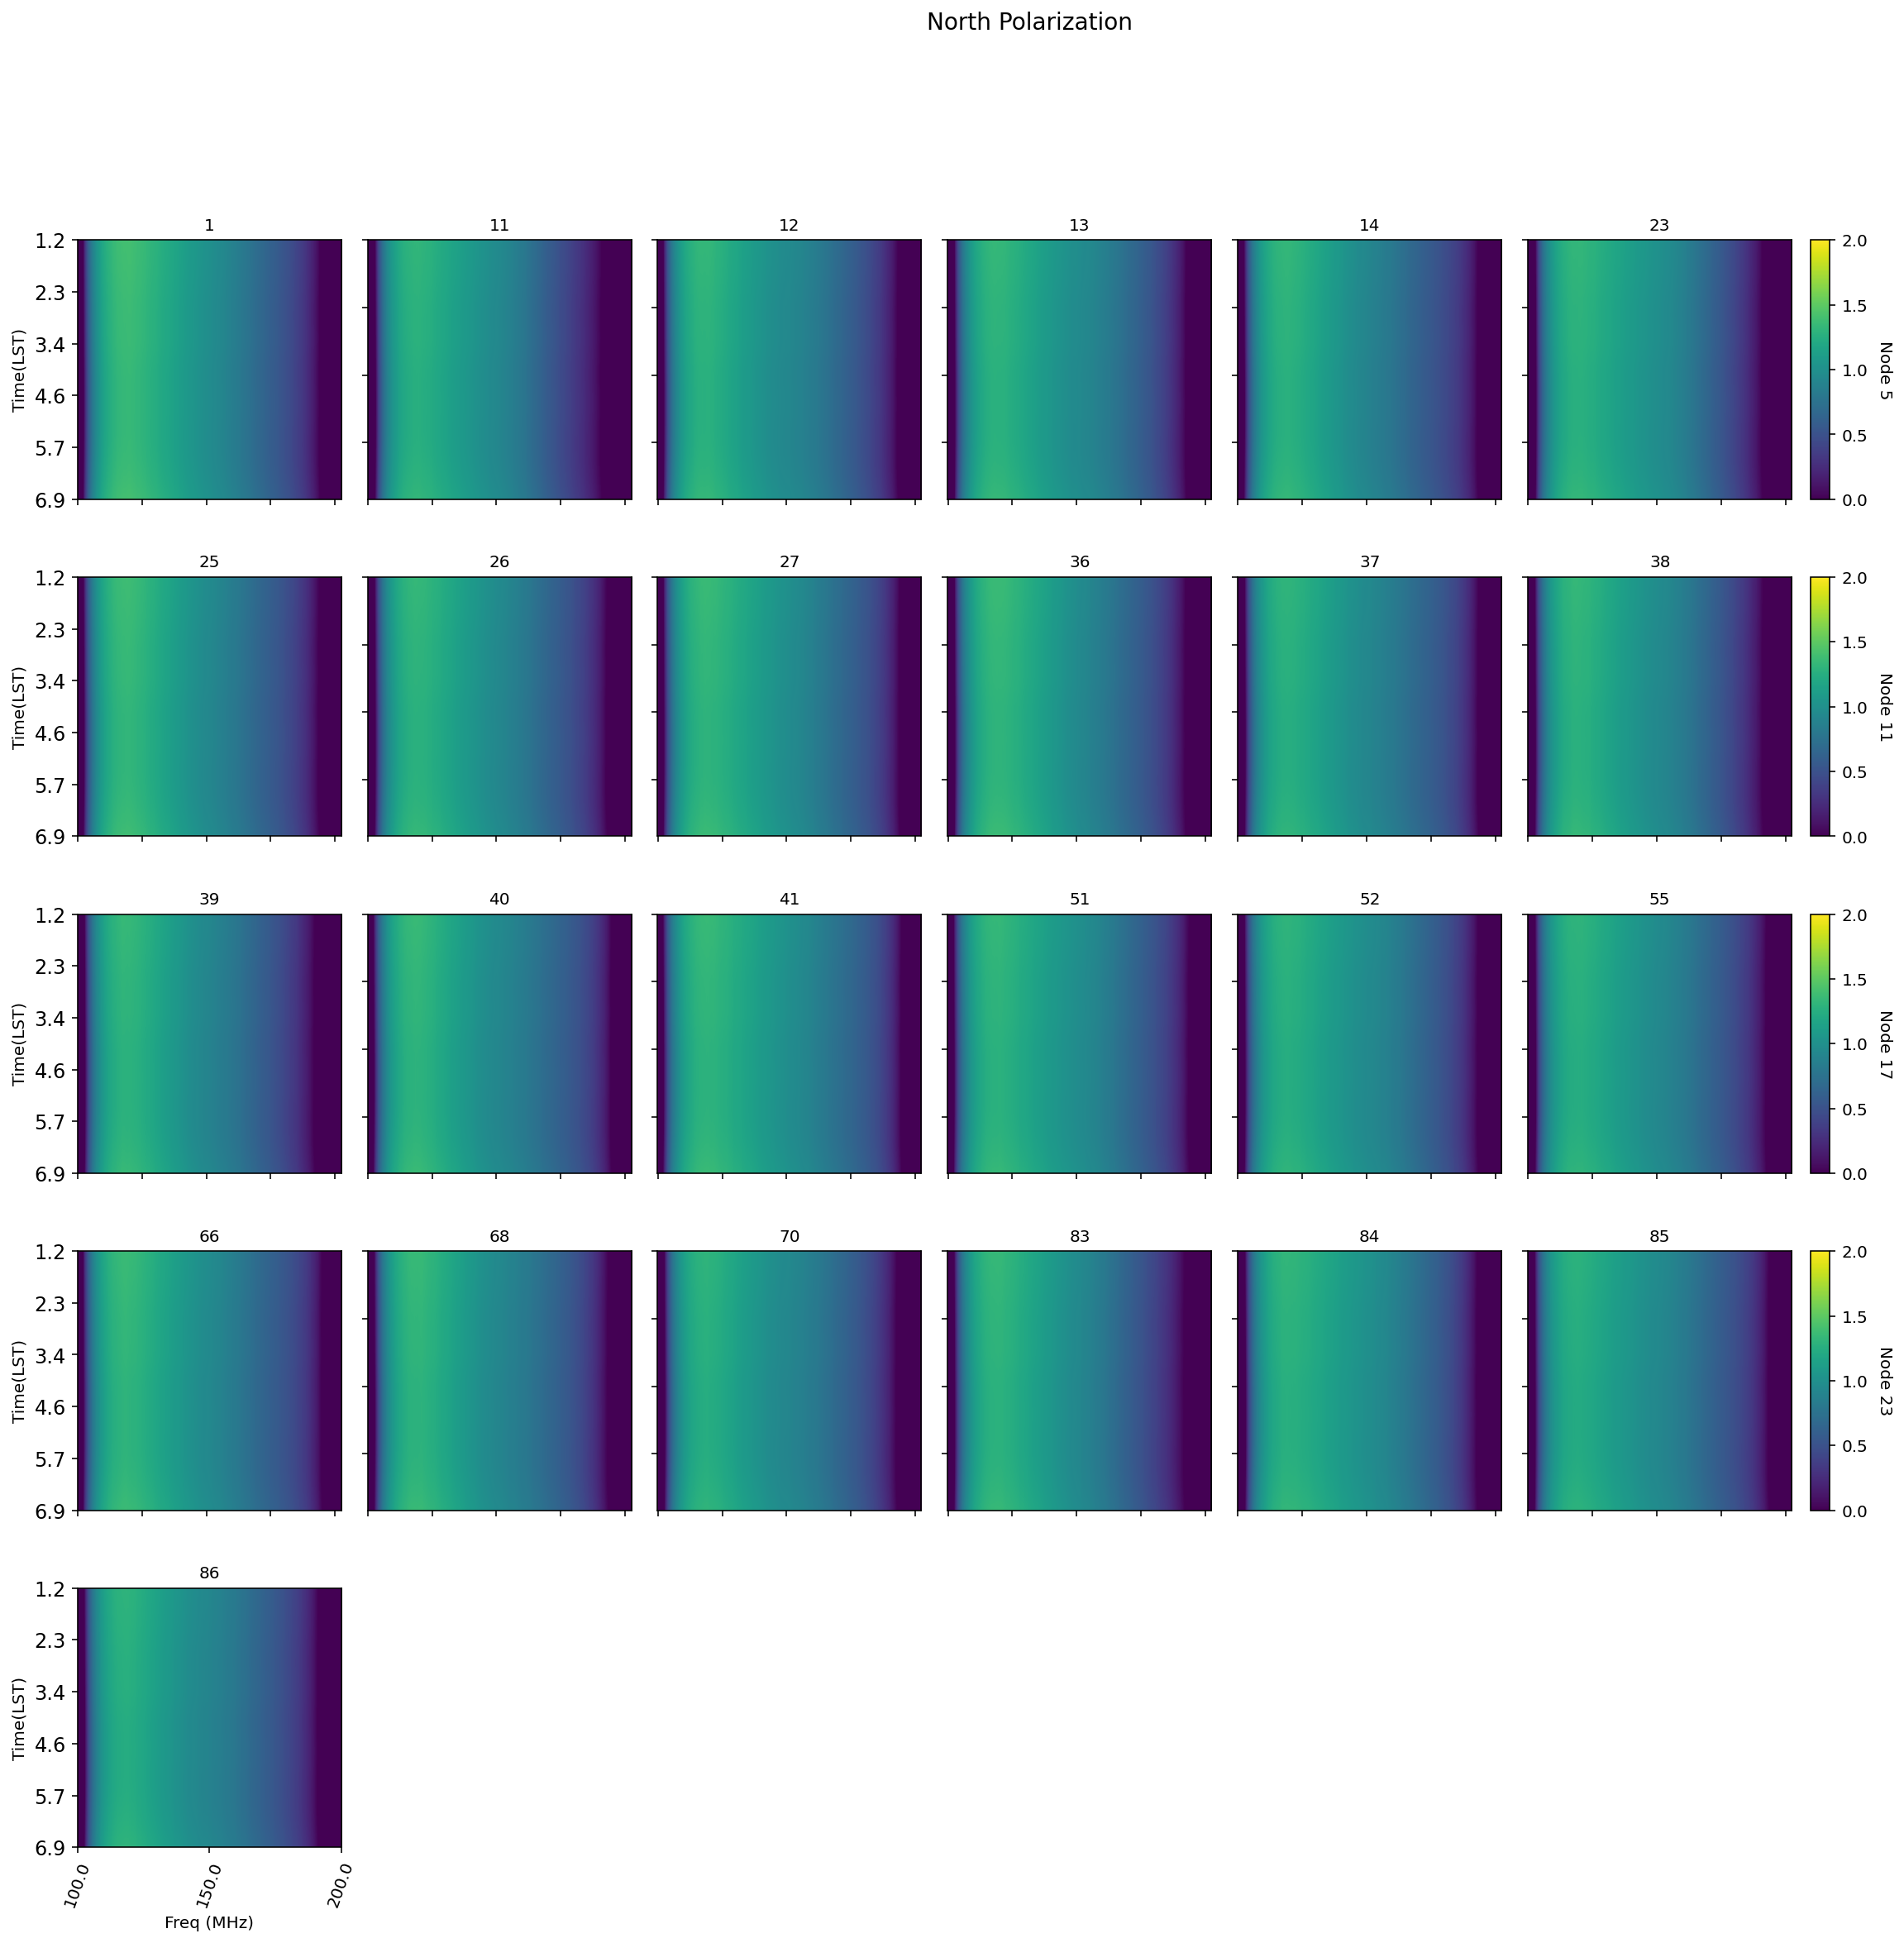

In [9]:
utils.plot_wfs(uvd, pol = 0)

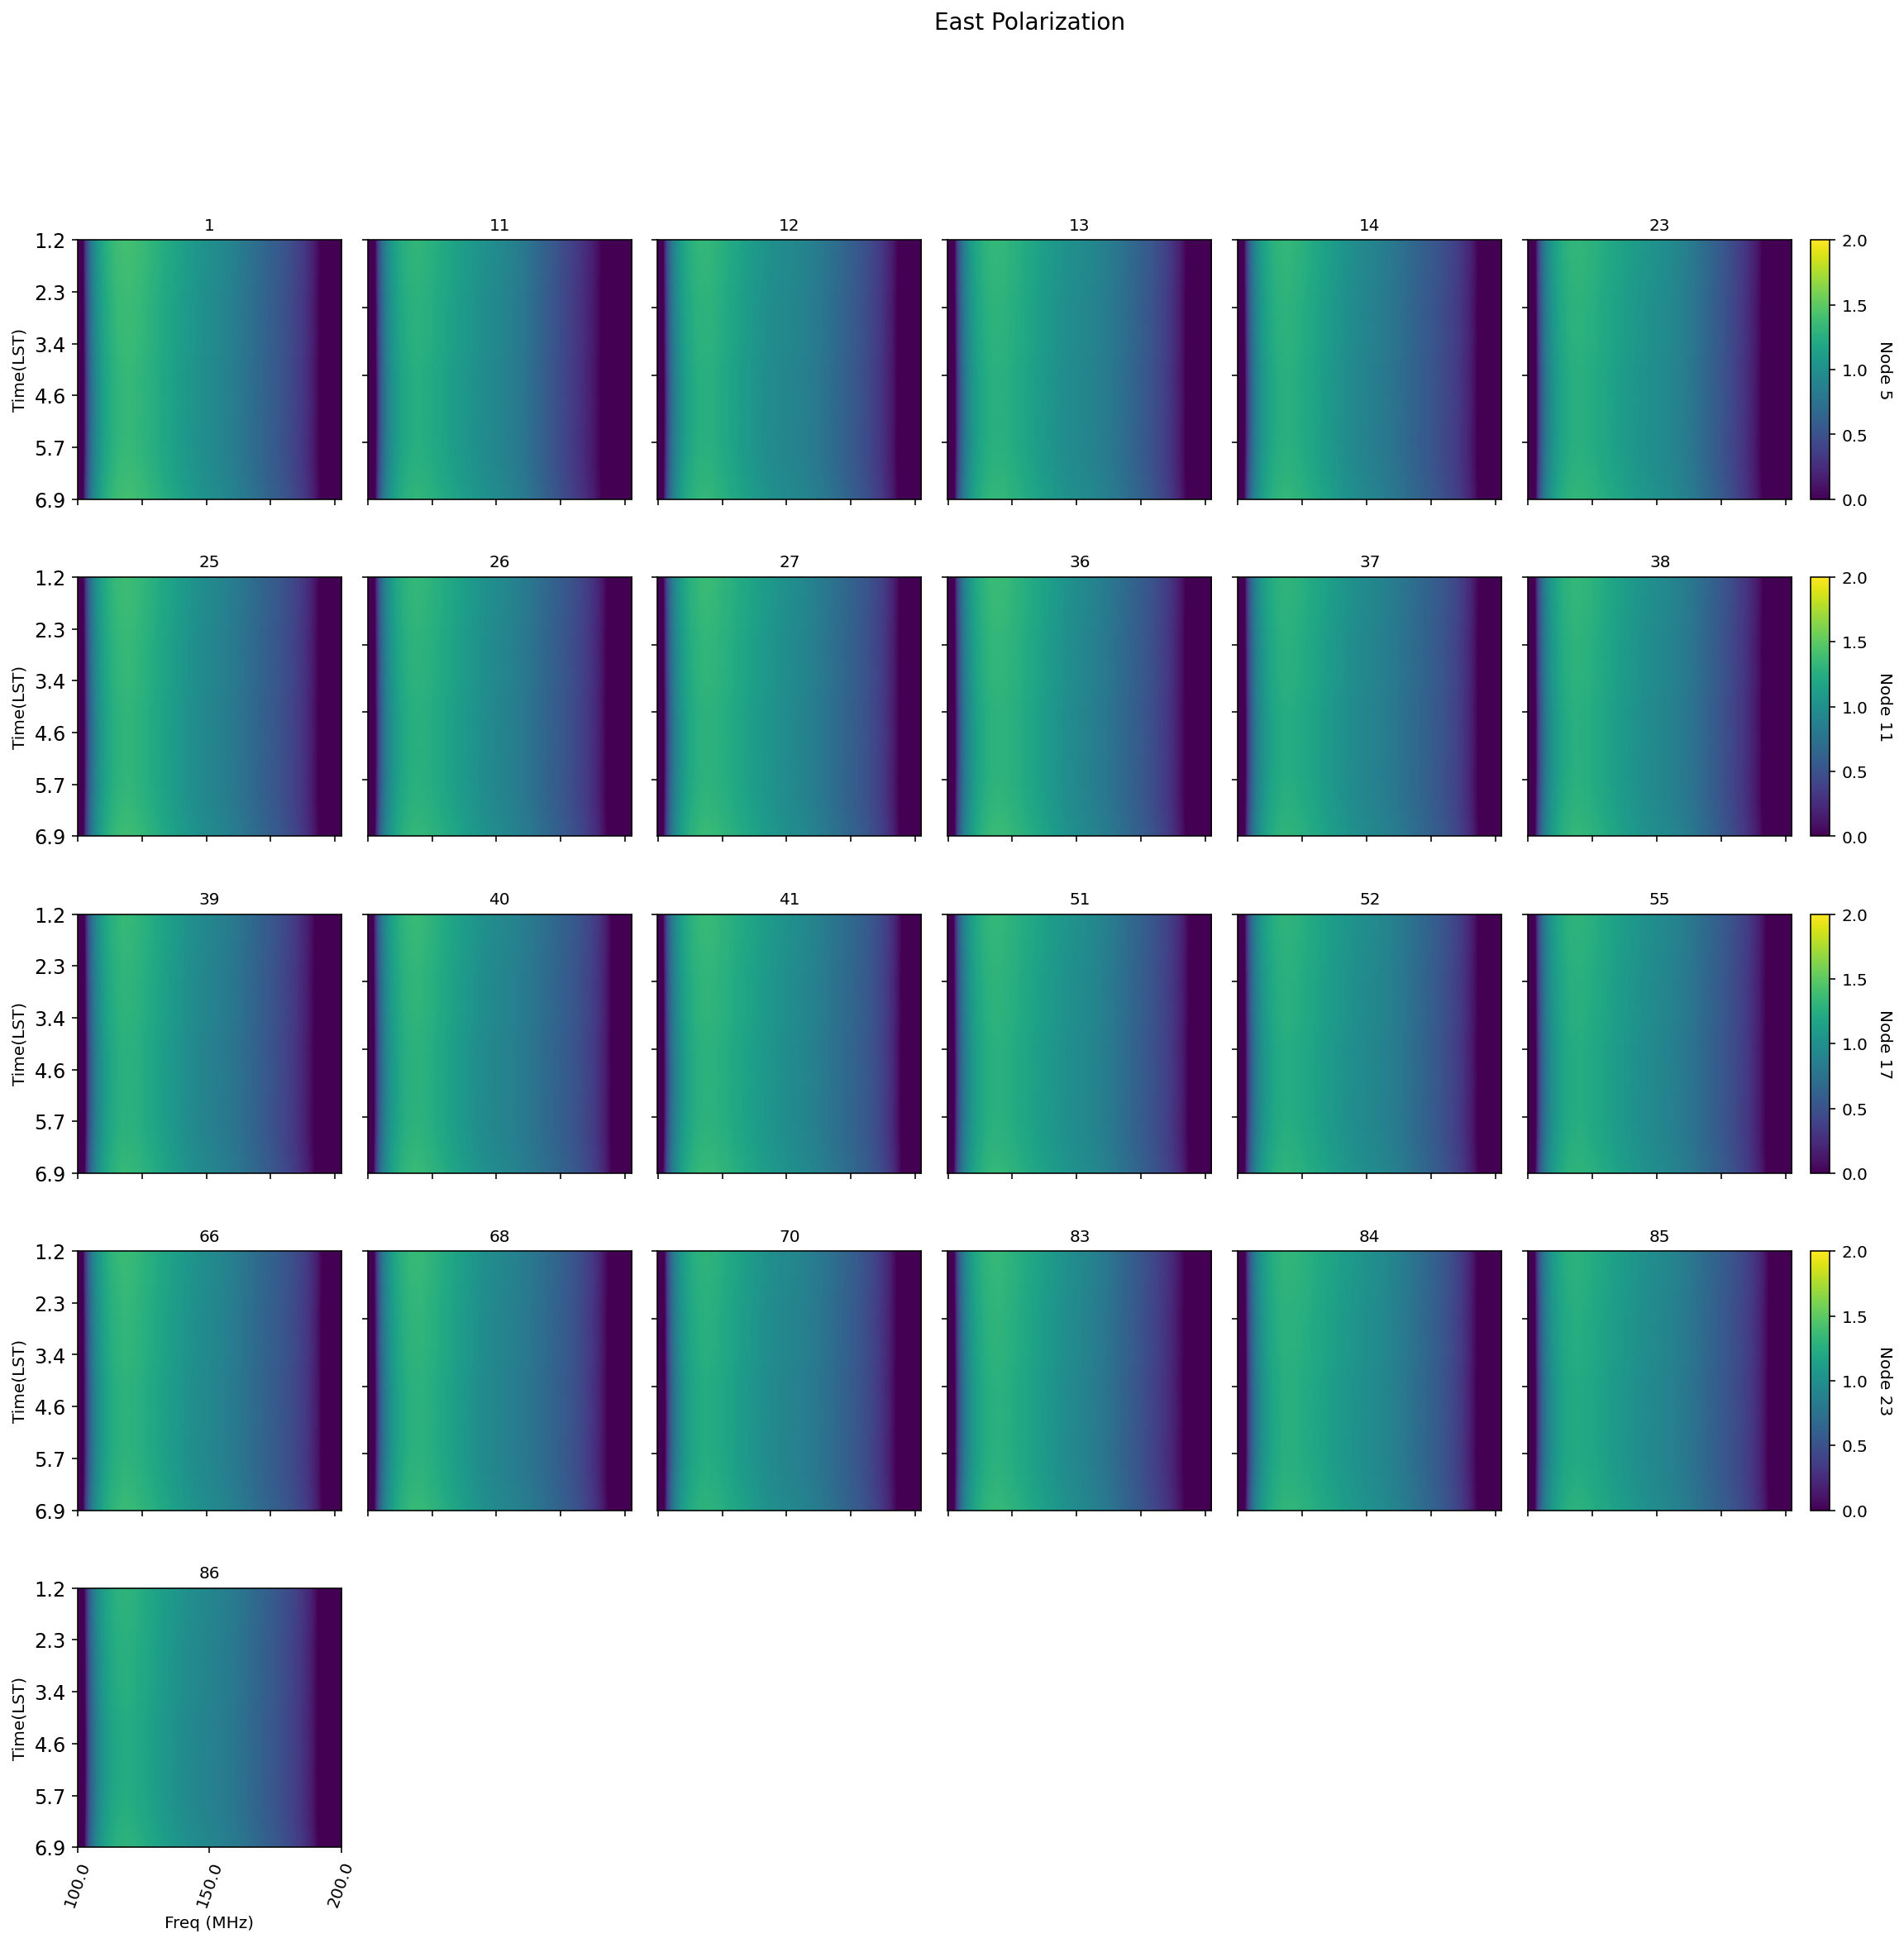

In [10]:
utils.plot_wfs(uvd, pol = 1)

## Correlation Metrics

The first plot shows the correlation metric (described below) for a set of baseline types, as calculated at several times throughout the night. It is expected that longer baselines (darker color) will exhibit lower values than the short baselines. 

The matrices show the phase correlation between antennas. Using the even and odd visibilities, each pixel is calculated as (even/abs(even)) * (conj(odd)/abs(odd)), and then averaged across time and frequency. If the phases are noise-like, this value will average down to zero. If the antennas are well correlated, the phases should not be noise-like, and this value should average to 1. The lines denoting node boundaries are intended to help confirm that inter-node correlations are functioning - if they aren't, this plot will appear block-diagonal.

This metric has shown to be LST locked - when comparing to other nights, be sure to compare for the same LST. It is expected that some LSTs will look much better or worse than others.

Note: Within each node, the order of antennas is determined by snap, and within that by snap input number. 

In [11]:
badAnts = []
badAnts = utils.plotNodeAveragedSummary(uvd,HHfiles,JD,use_ants,mat_pols=['xx','yy','xy','yx'])

KeyError: 'Polarization xy not found in data.'

## Antenna Positions

Antennas outlined in black here have been identified by the correlation matrix as bad antennas. Antennas with a colorful outline correspond to their status as identified by ant_metrics (see above plot). Faded antennas are those not meeting the apriori status requirement for this notebook run. Gold stars are node box locations.

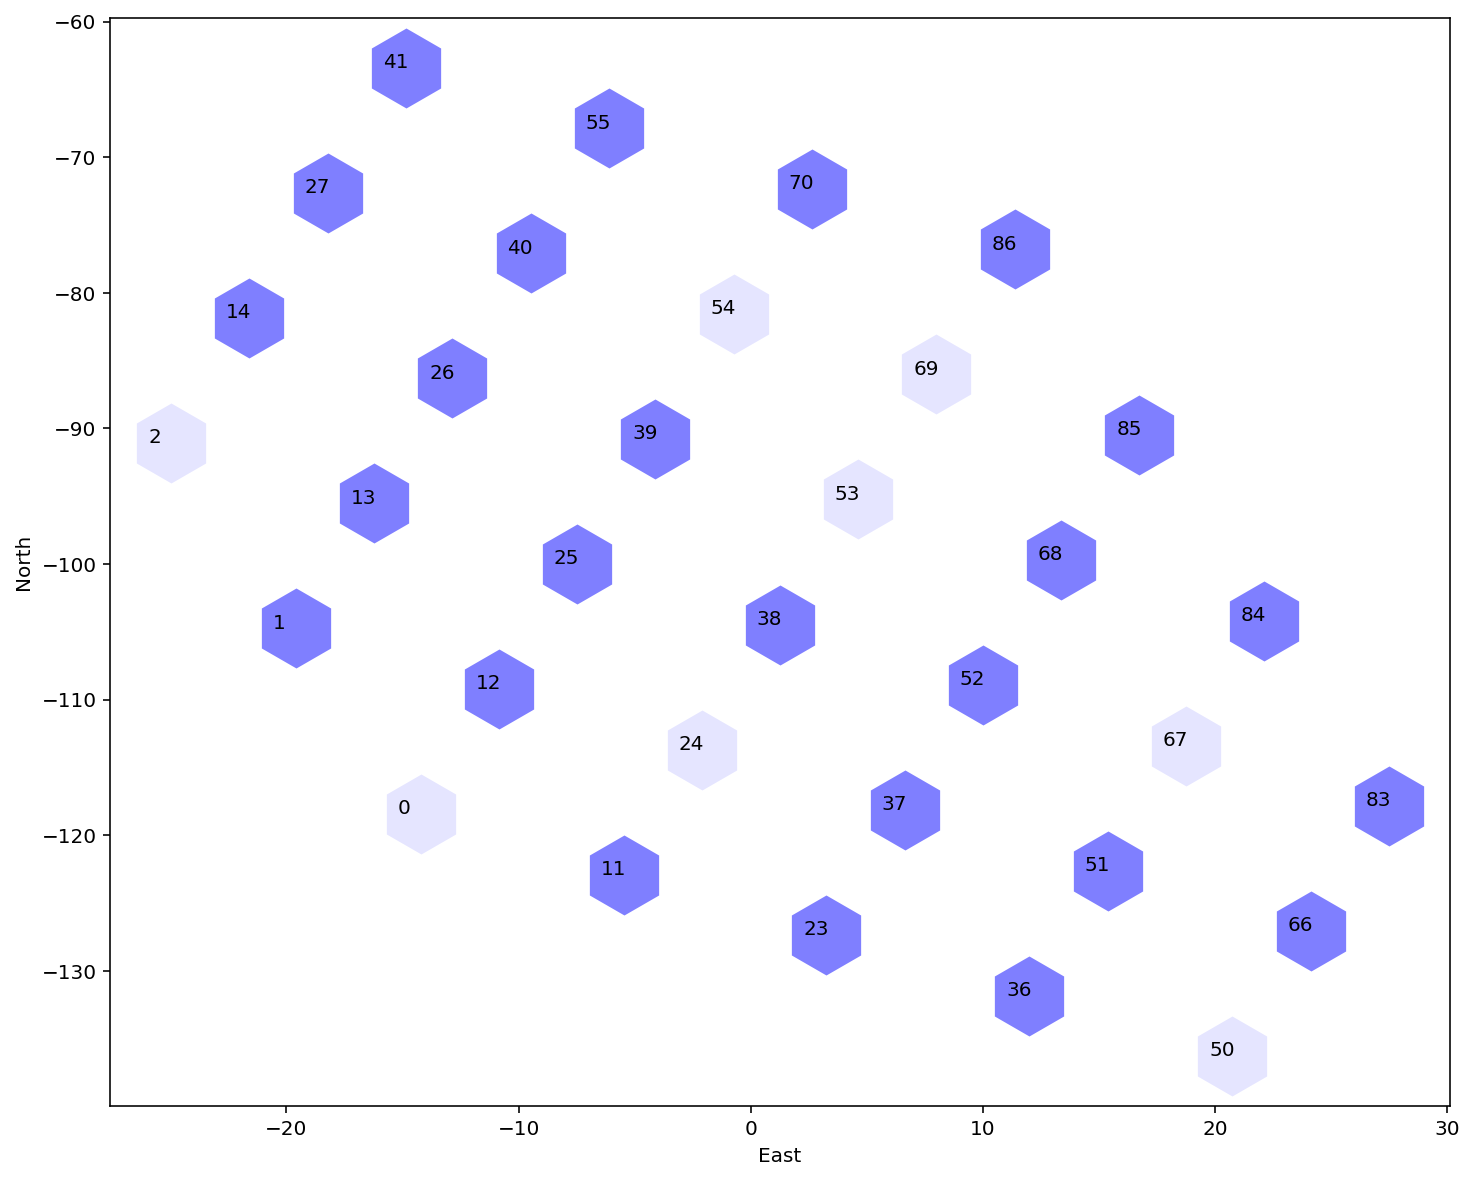

In [12]:
uvd1 = UVData()
uvd1.read(HHfiles[readInd], skip_bad_files=True)
utils.plot_antenna_positions(uvd1, badAnts=badAnts,use_ants=use_ants)

## Mean-Subtracted Waterfalls

Here the mean value in each frequency bin has been subtracted out. This effectively subtracts out the bandpass shape, making time variations more visible.

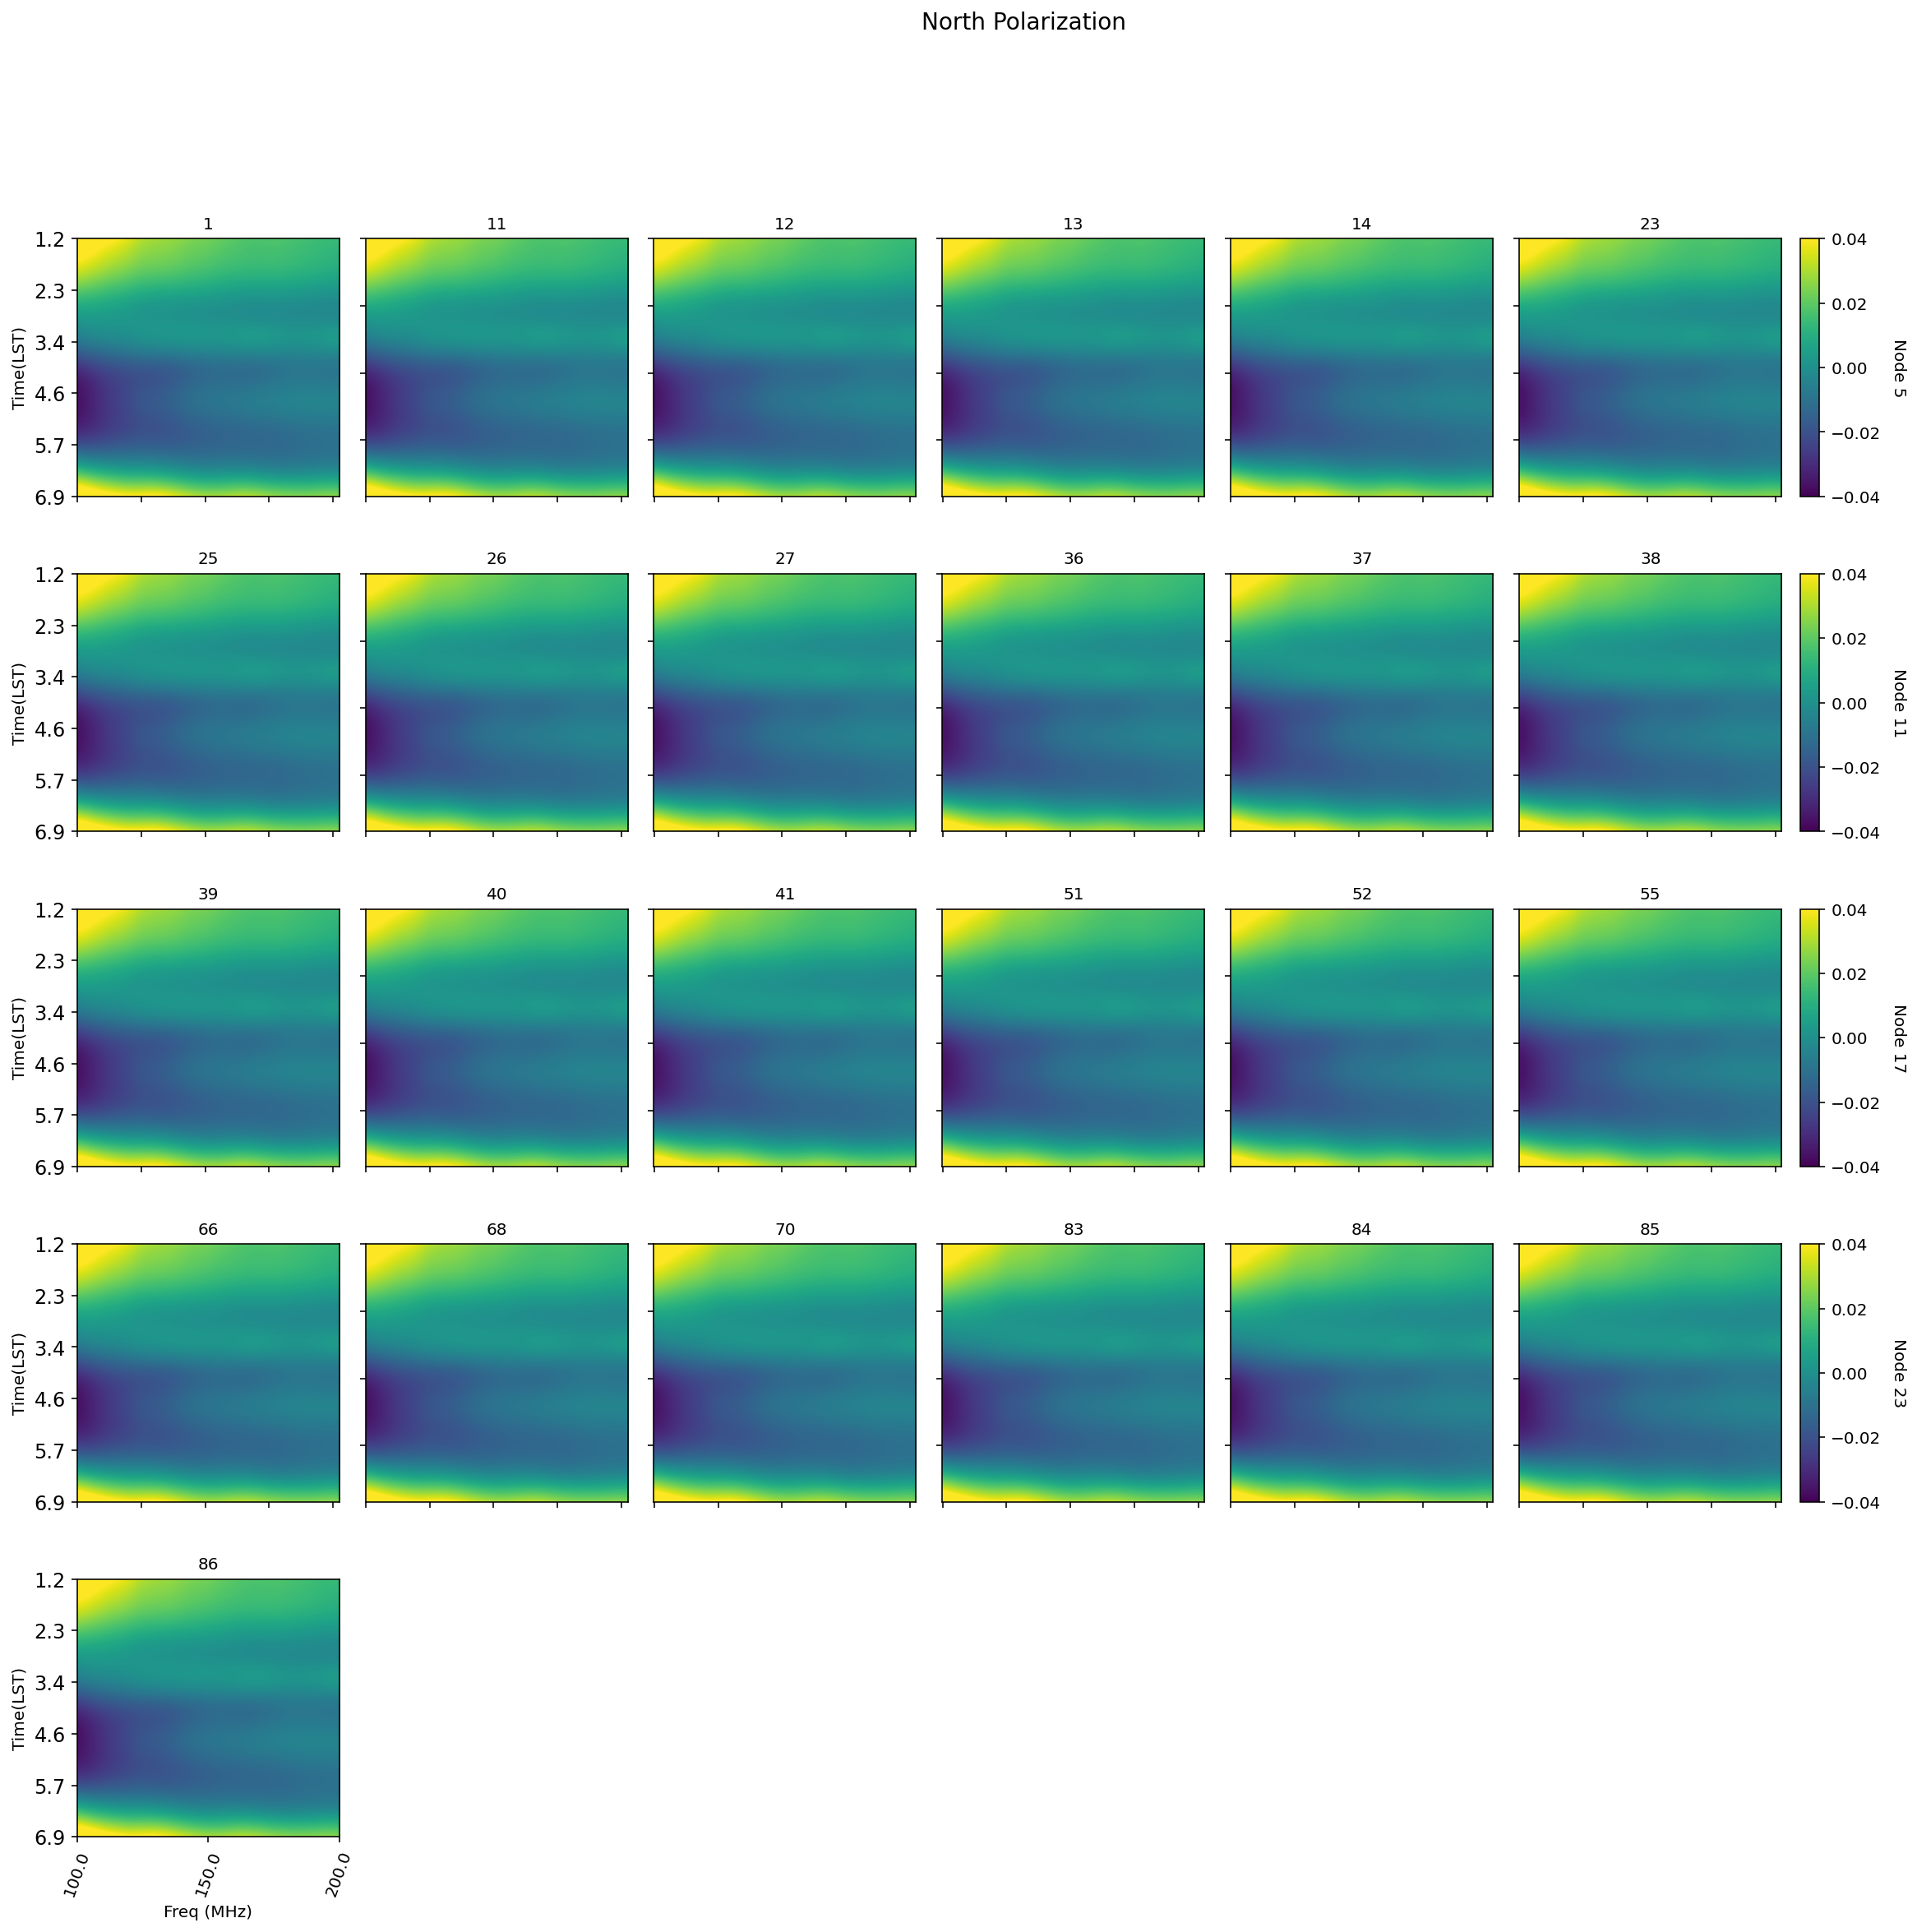

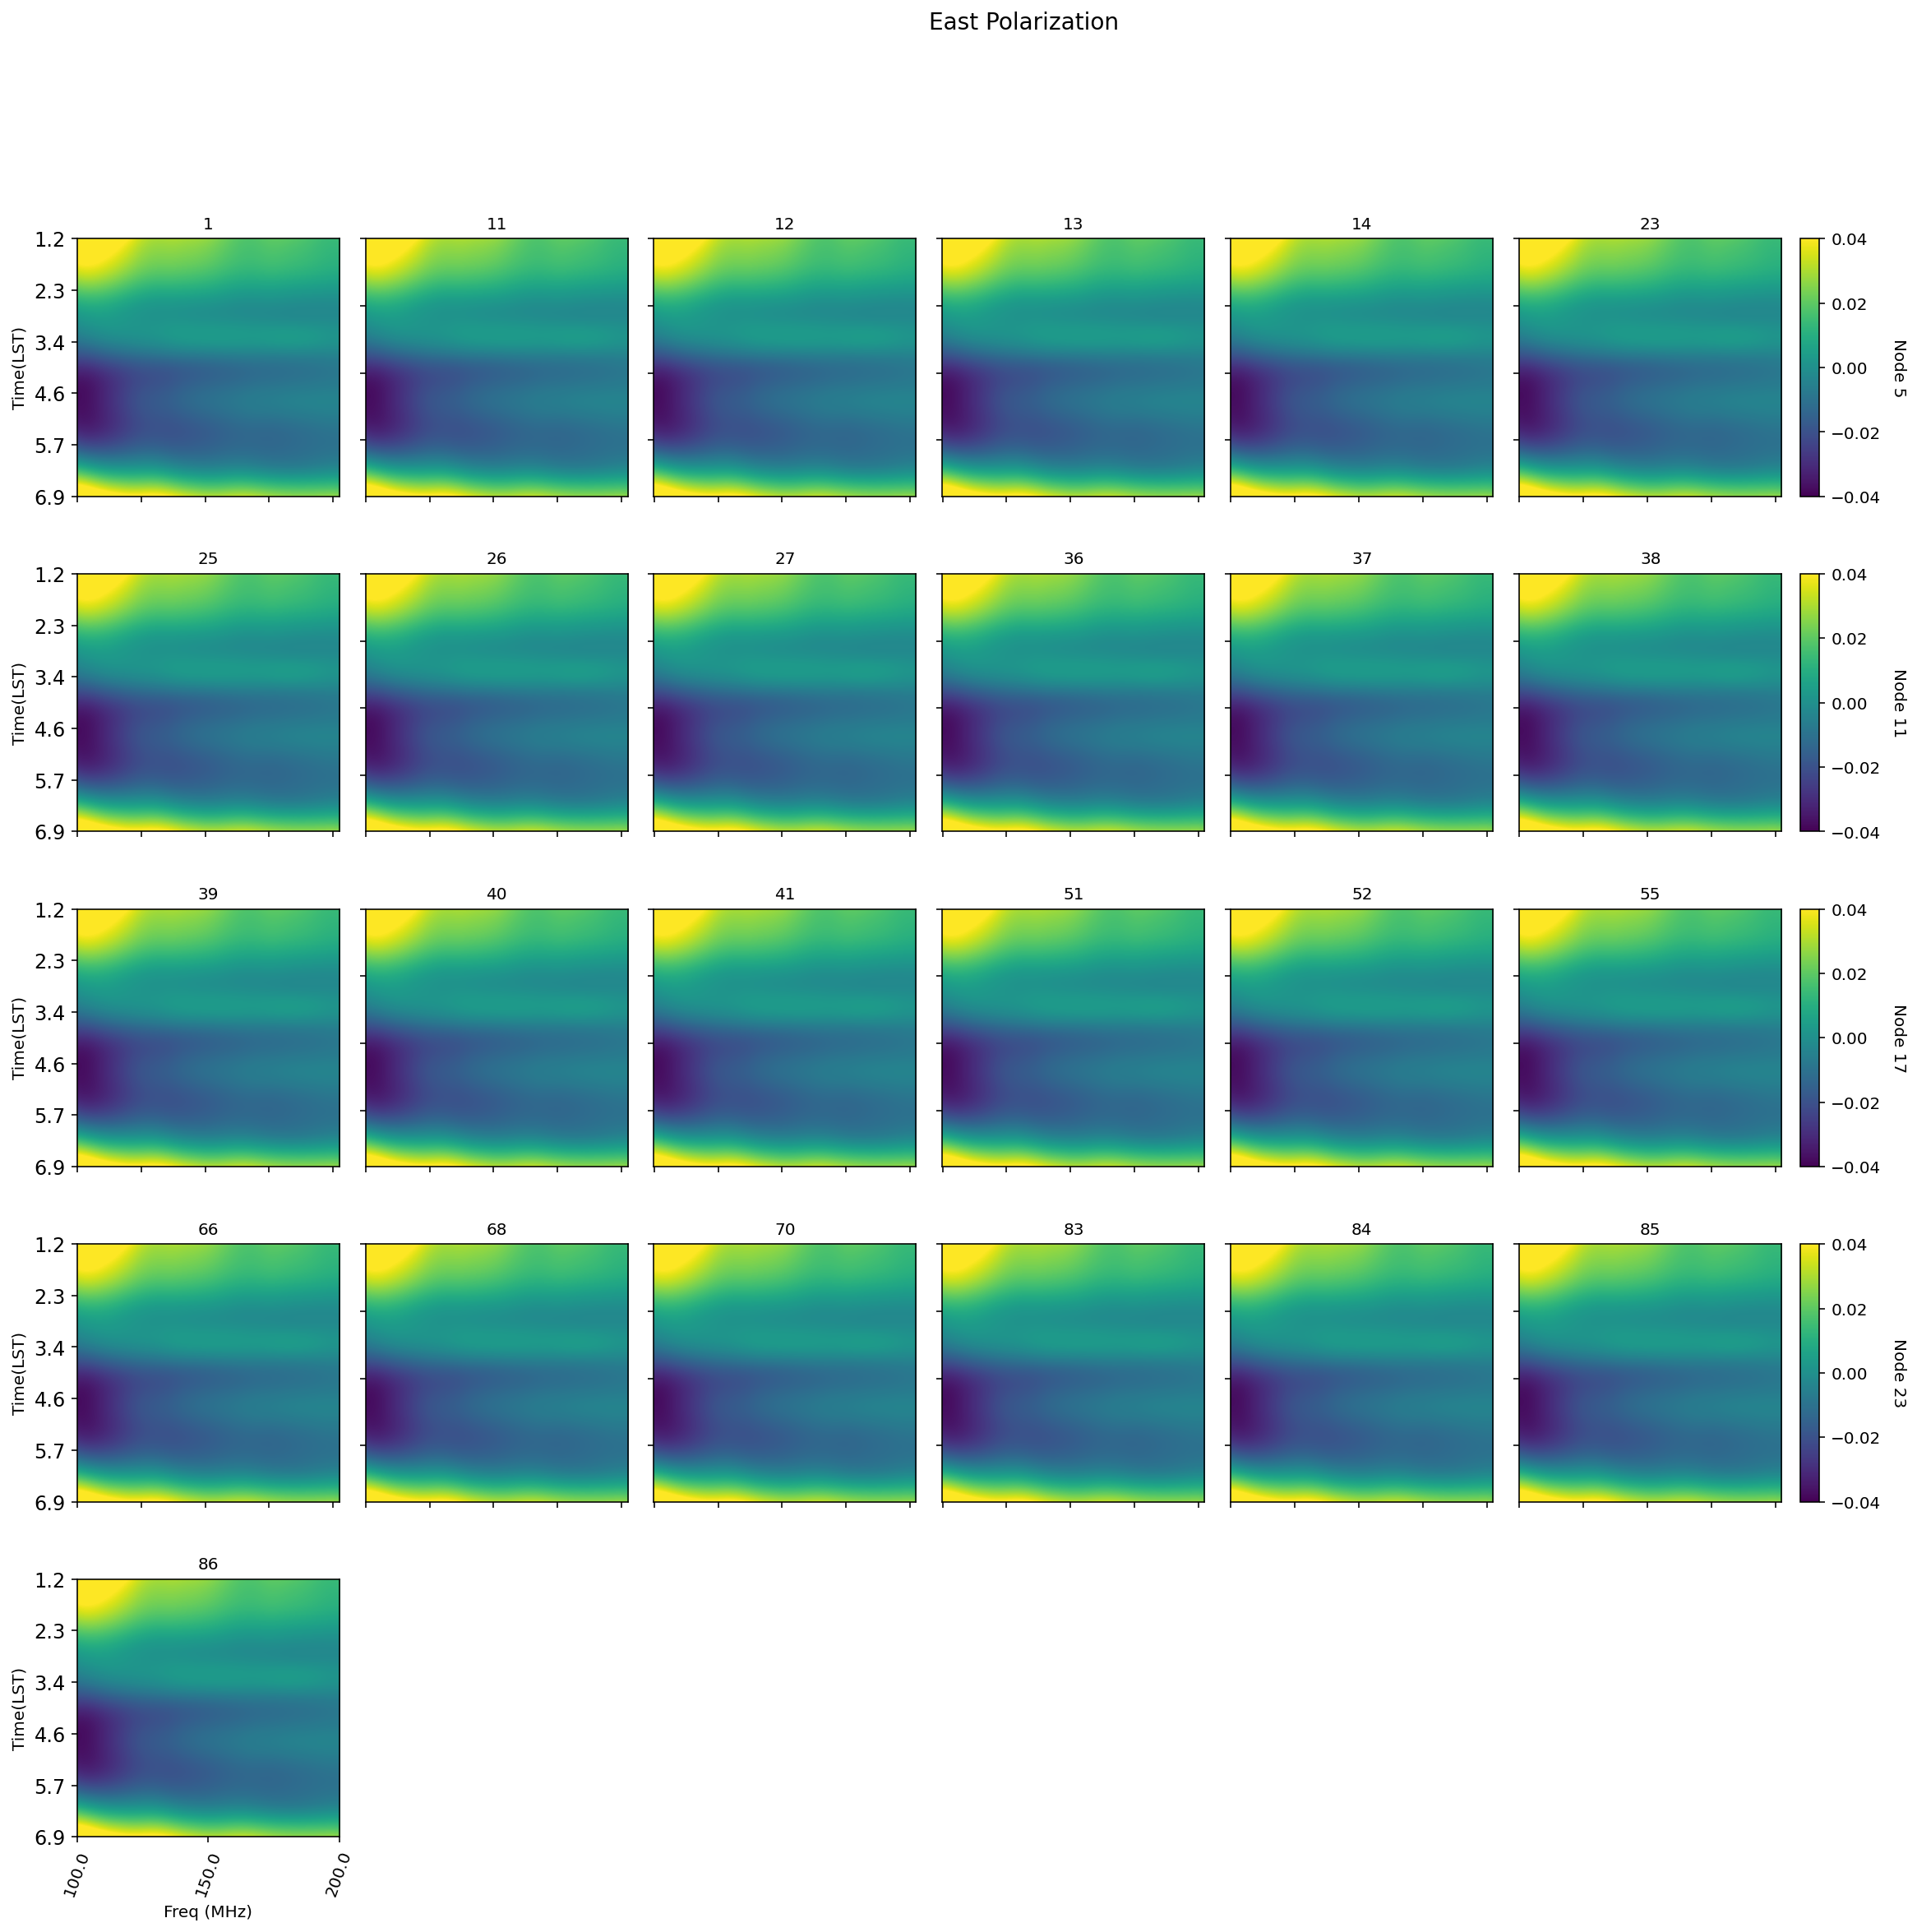

In [13]:
utils.plot_wfs(uvd,0,mean_sub=True,jd=JD)
utils.plot_wfs(uvd,1,mean_sub=True,jd=JD)